In [67]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))



### Get feature importance

#### Feature selection

TO DO: READ ABOUT RECURSIVE FEATURE ELIMINTATION!!!!

Do recursive feature elimination first, then decision tree, get feature importance , set a threshold and choose the top 5 most important features


L1 (L2) regularization

PCA, then random forest classifier, get feature importance 

Autoencoder

#### Clustering

KMEANS
DBSCAN (sklearn)

## To do: clustering fuel only cars
1. T-SNE, read about it, do dimensionality reduction

## Pair wise clustering
1. Hybrid and electric
2. Hybrid and fuel

## Fuzzy logic
Can we calculate car membership?
Read on fuzzy logic 

## Consumer analysis with scraped data 
Predictor for time series sales data
Couple sales data with the co2 scores
Accumulated prediction for co2 impact 


In [68]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(Path("../data/predicted-data/","predicted_co2_rating.csv"))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26961 entries, 0 to 26960
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   vehicleclass_                  26961 non-null  object 
 1   make_                          26961 non-null  object 
 2   model.1_                       26961 non-null  object 
 3   model_year                     26961 non-null  int64  
 4   cylinders_                     26961 non-null  float64
 5   fuelconsumption_city(l/100km)  26961 non-null  float64
 6   fuelconsumption_hwy(l/100km)   26961 non-null  float64
 7   fuelconsumption_comb(l/100km)  26961 non-null  float64
 8   co2emissions_(g/km)            26961 non-null  int64  
 9   number_of_gears                26961 non-null  float64
 10  predicted_co2_rating           26961 non-null  int64  
 11  original_co2r                  7973 non-null   float64
 12  enginesize_(l)                 26961 non-null 

In [69]:
X = df[['predicted_co2_rating','model_year', 'cylinders_', 'fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)',
        'fuelconsumption_comb(l/100km)', 'number_of_gears', 'enginesize_(l)',
        'fuelconsumption_comb(mpg)', 'transmission_type', 'mapped_fuel_type', 
        'type_of_wheel_drive']]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['mapped_fuel_type', 
                                'transmission_type', 
                                'type_of_wheel_drive'])

# create target variable
y = df['predicted_co2_rating']

# initialize RFE with DT as estimator
dt = DecisionTreeClassifier(random_state=0)
rfe = RFE(dt, n_features_to_select=5, step=1)

# fit RFE
rfe.fit(X, y)

# get top 5 important features
top_features = X.columns[rfe.support_].tolist()
print("Top 5 important features:", top_features)

Top 5 important features: ['predicted_co2_rating', 'type_of_wheel_drive_Long wheelbase', 'type_of_wheel_drive_Natural gas vehicle', 'type_of_wheel_drive_Short wheelbase', 'type_of_wheel_drive_unspecified']


In [72]:
# select only the top 5 important features
X = X[['predicted_co2_rating', 'type_of_wheel_drive_Long wheelbase', 'type_of_wheel_drive_Natural gas vehicle', 'type_of_wheel_drive_Short wheelbase', 'type_of_wheel_drive_unspecified']]

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# perform KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_scaled)

# perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# add the cluster labels to the DataFrame
df['kmeans_cluster'] = kmeans_labels
df['dbscan_cluster'] = dbscan_labels

For n_clusters = 2 The inertia score is : 107423.54087383825 The average silhouette score is : 0.6356250751611014
For n_clusters = 3 The inertia score is : 80492.9330518486 The average silhouette score is : 0.634211380578861
For n_clusters = 4 The inertia score is : 53616.1320994011 The average silhouette score is : 0.6317053968792202
For n_clusters = 5 The inertia score is : 26891.739160013716 The average silhouette score is : 0.6265722006382904
For n_clusters = 6 The inertia score is : 11554.34570015119 The average silhouette score is : 0.6282849797849589
For n_clusters = 7 The inertia score is : 7060.125222880513 The average silhouette score is : 0.6632339260212068
For n_clusters = 8 The inertia score is : 5036.176753982333 The average silhouette score is : 0.6588459547622884
For n_clusters = 9 The inertia score is : 3719.94188618373 The average silhouette score is : 0.6669197224896763
For n_clusters = 10 The inertia score is : 2528.9548607278516 The average silhouette score is : 0.

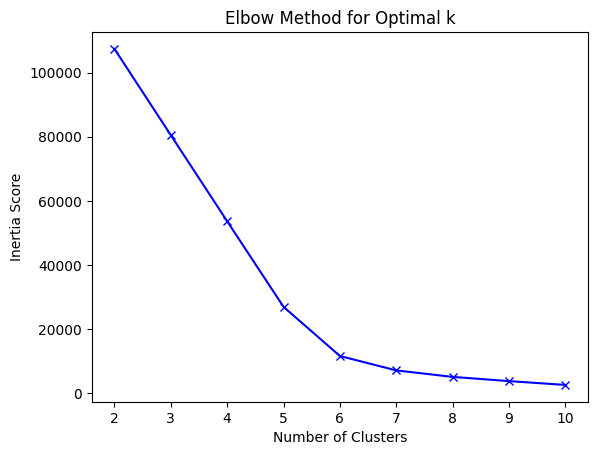

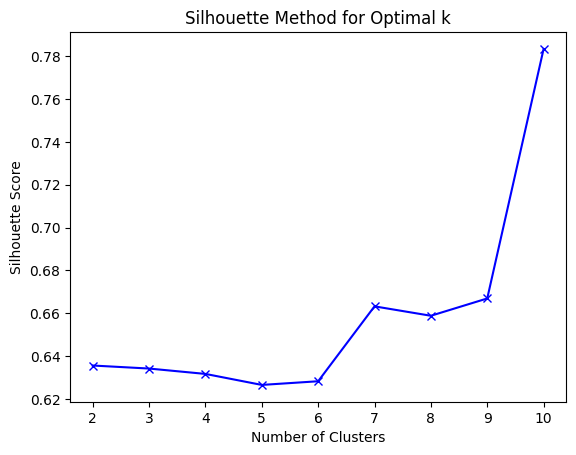

Number of clusters in DBSCAN: 22


In [73]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# select the top 5 important features
# select only the top 5 important features
X = X[['predicted_co2_rating', 
'type_of_wheel_drive_Long wheelbase', 
'type_of_wheel_drive_Natural gas vehicle', 
'type_of_wheel_drive_Short wheelbase',
 'type_of_wheel_drive_unspecified']]

# standardize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)

# create a range of cluster numbers
range_n_clusters = range(2, 11)

# initialize lists to store the scores
silhouette_scores = []
inertia_scores = []

# loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    
    # initialize KMeans with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    
    # fit KMeans to the data
    kmeans.fit(X)
    
    # calculate the inertia score (within-cluster sum of squares)
    inertia_scores.append(kmeans.inertia_)
    
    # calculate the silhouette score
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # print the scores
    print("For n_clusters =", n_clusters,
          "The inertia score is :", kmeans.inertia_,
          "The average silhouette score is :", silhouette_avg)

# plot the elbow curve
plt.plot(range_n_clusters, inertia_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.title('Elbow Method for Optimal k')
plt.show()

# plot the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# initialize DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)

# fit DBSCAN to the data
dbscan.fit(X)

# print the number of clusters (unique labels) in DBSCAN
print("Number of clusters in DBSCAN:", len(np.unique(dbscan.labels_)))


In [76]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# select the top 5 important feature
# Define function to perform DBSCAN clustering and return the cluster labels and silhouette score
def perform_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return cluster_labels, silhouette_avg

# Define function to plot the results of DBSCAN clustering
def plot_dbscan(X, cluster_labels):
    # plot the clusters
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()




In [ ]:
# Define the parameters for DBSCAN clustering
eps = 0.3
min_samples = 10

def generate_dbsca_plot(var1, var2):
    print('DBSCAN clustering for', var1, 'and', var2)
    # Perform DBSCAN clustering on the data
    X = df[[var1, 
        var2]].values
    cluster_labels, silhouette_avg = perform_dbscan(X, eps, min_samples)

    # Print the silhouette score and number of clusters found
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print('Number of clusters in DBSCAN:', n_clusters)
    print('The average silhouette score is :', silhouette_avg)

    # Plot the results of DBSCAN clustering
    plot_dbscan(X, cluster_labels)




In [77]:
from sklearn import metrics

def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    silhouette_scores = []
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters > 1:
                silhouette_score = metrics.silhouette_score(X, labels)
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters,
                      "and the average silhouette score is", silhouette_score)
                silhouette_scores.append(silhouette_score)
            else:
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters)
    # print the parameter combination with the highest silhouette score
    max_index = silhouette_scores.index(max(silhouette_scores))
    eps_index = max_index // len(min_samples_list)
    min_samples_index = max_index % len(min_samples_list)
    best_eps = eps_list[eps_index]
    best_min_samples = min_samples_list[min_samples_index]
    print("The best parameter combination is eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters > 1:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is :", silhouette_score)
    else:
        print("DBSCAN only found one cluster")

# example usage
X = df[['model_year', 'cylinders_', 
    'fuelconsumption_city(l/100km)', 'fuelconsumption_comb(l/100km)', 
    'fuelconsumption_comb(mpg)']].values
eps_list = [0.5, 1, 2, 4, 8, 16]
min_samples_list = [5, 10, 20, 50]

best_eps, best_min_samples = find_best_dbscan_params(X, eps_list, min_samples_list)
perform_best_dbscan(X, best_eps, best_min_samples)

For eps = 0.5 and min_samples = 5 the number of clusters is 1121 and the average silhouette score is 0.4494216570044461
For eps = 0.5 and min_samples = 10 the number of clusters is 772 and the average silhouette score is 0.29779996588222746
For eps = 0.5 and min_samples = 20 the number of clusters is 441 and the average silhouette score is -0.003515205268807212
For eps = 0.5 and min_samples = 50 the number of clusters is 31 and the average silhouette score is -0.5477218390748099
For eps = 1 and min_samples = 5 the number of clusters is 201 and the average silhouette score is -0.5128198077343805
For eps = 1 and min_samples = 10 the number of clusters is 125 and the average silhouette score is -0.49488245704455536
For eps = 1 and min_samples = 20 the number of clusters is 81 and the average silhouette score is -0.47795354117011835
For eps = 1 and min_samples = 50 the number of clusters is 39 and the average silhouette score is -0.5145061485072407
For eps = 2 and min_samples = 5 the numbe

In [83]:
def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    max_silhouette_score = -1
    best_eps, best_min_samples = None, None
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters == 1:
                continue
            silhouette_score = metrics.silhouette_score(X, labels)
            if silhouette_score > max_silhouette_score:
                max_silhouette_score = silhouette_score
                best_eps, best_min_samples = eps, min_samples
                print("For eps =", eps, "and min_samples =", min_samples,
                        "the number of clusters is", n_clusters,
                        "and the average silhouette score is", silhouette_score)
            
    # print the best hyperparameters
    print("The best hyperparameters for 2 clusters are: eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters == 2:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is:", silhouette_score)
    else:
        print("DBSCAN did not find 2 clusters")

# example usage
X = df[['model_year', 'cylinders_', 
    'fuelconsumption_city(l/100km)', 'fuelconsumption_comb(l/100km)', 
    'fuelconsumption_comb(mpg)']].values
eps_list = [0.5, 1, 2, 4, 8, 16]
min_samples_list = [5, 10, 20, 50]

best_eps, best_min_samples = find_best_dbscan_params(X, eps_list, min_samples_list)
perform_best_dbscan(X, best_eps, best_min_samples)

In [82]:
print(best_eps, best_min_samples)

4 10


In [ ]:
n_clu, label = perform_dbscan(X, 4, 50)

In [ ]:
# Perform DBSCAN clustering
db = DBSCAN(eps=4, min_samples=50)
labels = db.fit_predict(X)

# Add the cluster labels to the DataFrame
df['cluster'] = labels

In [ ]:
# get the cluster labels for the best hyperparameters
n_clu, labels = perform_dbscan(X, 4, 50)

# plot the data points with color representing cluster labels
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

In [ ]:
# plot the data points with color representing cluster labels
plt.scatter(X[:, 0], X[:, 2], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

In [ ]:
# plot the data points with color representing cluster labels
plt.scatter(X[:, 0], X[:, 2], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

In [ ]:
# plot the data points with color representing cluster labels
plt.scatter(X[:, 0], X[:, 3], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

In [ ]:
# plot the data points with color representing cluster labels
plt.scatter(X[:, 0], X[:, 4], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

In [ ]:
# plot the data points with color representing cluster labels
plt.scatter(X[:, 3], X[:, 4], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()